# Notebook to Start Pulling it All Together

## Salinity 5 m and deeper

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [3]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [4]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [5]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [6]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [7]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [8]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [9]:
def plot_and_stats(temp1, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 36
    vmin = 12
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[temp1.k >= 5], temp1.mod_vosaline[temp1.k >= 5], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[temp1.k >=5], 'SA', 'mod_vosaline')
    m, c, syst, nonsyst = slope_inter(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    tspread = spread(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    ax.plot(np.arange(vmin, vmax, 0.5), c + m*np.arange(vmin, vmax, 0.5), 'r-');
    ax.arrow(13, 31, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(13, 33, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 31, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 33, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 31, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 33, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(13-0.2, 26, 'bias', rotation=90)
    ax.text(14-0.2, 25, 'systematic', rotation=90)
    ax.text(15-0.2, 24, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Salinity below 5 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [10]:
pieces = ('/home/sallen/202007/H201812/ObsModel_H201812_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1312447,0.15,0.5,0.056,0.13,4.1,0.21,0.45,0.07


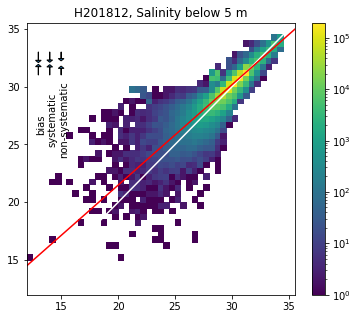

In [11]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
d201812 = plot_and_stats(temp1, 'H201812')
d201812.style.format(myformat)

In [12]:
pieces = (
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150101_20150331.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150301_20150630.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150601_20150930.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150901_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,1312447,0.14,0.5,0.055,0.12,3.8,0.19,0.46,0.049


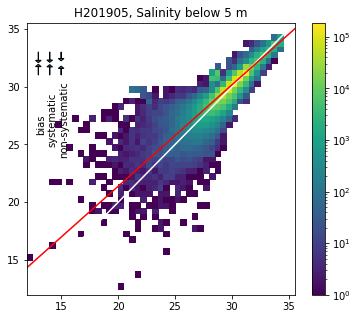

In [13]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
d201905 = plot_and_stats(temp1, 'H201905')
d201905.style.format(myformat)

## 2017 only

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,402501,0.25,0.67,0.09,0.2,6.3,0.34,0.57,0.11


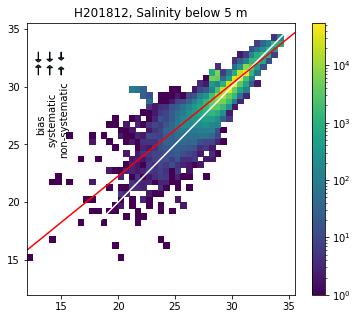

In [27]:
#temp1.set_index('dtUTC', inplace=True)
#temp1.sort_index(inplace=True)
#temp1.index = pd.to_datetime(temp1.index)
d201812 = plot_and_stats(temp1[temp1.index > dt.datetime(2017, 1, 1)], 'H201812')
d201812.style.format(myformat)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,402501,0.27,0.67,0.092,0.2,6.2,0.35,0.57,0.11


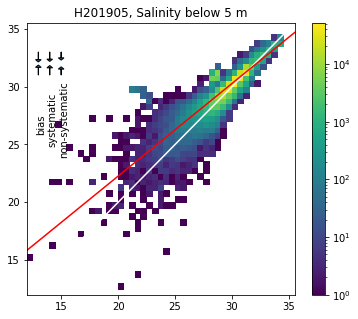

In [32]:
#temp1.set_index('dtUTC', inplace=True)
#temp1.sort_index(inplace=True)
#temp1.index = pd.to_datetime(temp1.index)
d201905 = plot_and_stats(temp1[temp1.index > dt.datetime(2017, 1, 1)], 'H201905')
d201905.style.format(myformat)

Change in along strait pressure is the major difference between 201812 and 201905.  We have gone back to 201812 (9.8 cm).
Analysis over the whole time period shows 201905 is better but the initial conditions for these runs is not the same.
If we look just at 2017, after the initial conditions have had time to disappear (201812 was started in 2015), we see drift to higher salinity bias but this drift is less in 201812, slightly supporting the higher pressure difference.

In [27]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20151001-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20160101-20160331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20160401-20160630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20160701-20160930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20161001-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170101-20170331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170401-20170630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170701-20170930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20171001-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20170101-20171231.csv')

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,552175,0.083425,0.456325,0.038736,0.084661,2.650741,0.130566,0.437247,0.026017


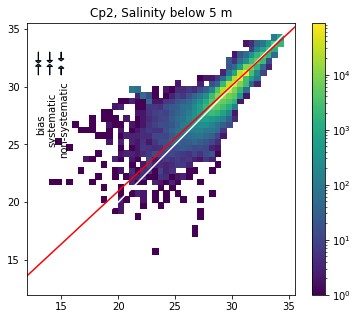

In [28]:
temp1 = read_pieces(pieces)
dCp2 = plot_and_stats(temp1, 'Cp2')
dCp2

In [18]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20151001-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20170101_20171231.csv'
        )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,1307892,0.13,0.49,0.055,0.12,3.9,0.19,0.46,0.052


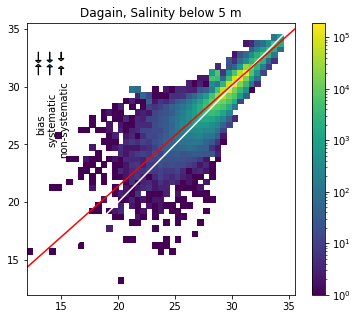

In [19]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
Dagain = plot_and_stats(temp1, 'Dagain')
Dagain.style.format(myformat)

In [20]:
pices = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20170101_20171231.csv')

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-noCil,1307892,0.13,0.49,0.055,0.12,3.9,0.19,0.46,0.052


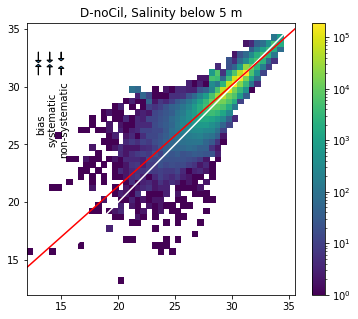

In [21]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DnoC = plot_and_stats(temp1, 'D-noCil')
DnoC.style.format(myformat)

In [31]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20170101_20171231.csv',)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,559683,0.081773,0.456044,0.03812,0.082283,2.577652,0.127826,0.437764,0.023206


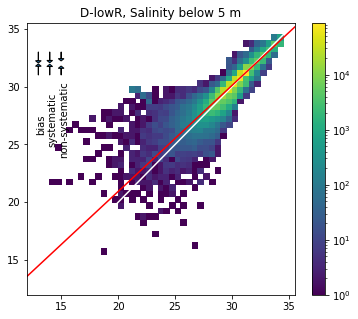

In [32]:
temp2 = read_pieces(pieces)
DlowR = plot_and_stats(temp2, 'D-lowR')
DlowR

In [33]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,559683,0.076,0.42,0.031,0.053,1.7,0.099,0.41,-0.013


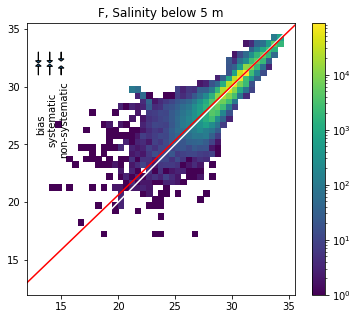

In [34]:
temp2 = read_pieces(pieces)
modF = plot_and_stats(temp2, 'F')
modF.style.format(myformat)

Note the hook at obs=22, model=30 : what is this?

In [41]:
temp2.keys()

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Z', 'SA',
       'CT', 'Fluor', 'dtUTC', 'j', 'i', 'mod_nitrate', 'mod_silicon',
       'mod_ammonium', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates',
       'mod_vosaline', 'mod_votemper', 'k', 'Station', 'Basin', 'Sigma', 'Chl',
       'SiteCode'],
      dtype='object')

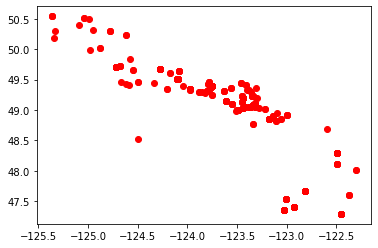

In [44]:
plt.plot(temp2.Lon[(temp2.SA < 25) & (temp2.mod_vosaline >27)],
         temp2.Lat[(temp2.SA < 25) & (temp2.mod_vosaline >27)], 'ro');

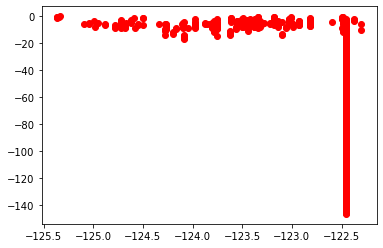

In [46]:
plt.plot(temp2.Lon[(temp2.SA < 25) & (temp2.mod_vosaline >27)],
         -temp2.Z[(temp2.SA < 25) & (temp2.mod_vosaline >27)], 'ro');

In [24]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [37]:
alltogether = pd.concat([d201812,d201905, dCp2, Dagain, DlowR, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1315785,0.12,0.45,0.041,0.097,3.0,0.16,0.42,0.17
H201905,1387394,0.11,0.44,0.038,0.087,2.7,0.15,0.42,0.16
Cp2,552175,0.083,0.46,0.039,0.085,2.7,0.13,0.44,0.026
Dagain,555128,0.084,0.46,0.039,0.084,2.6,0.13,0.44,0.025
D-lowR,559683,0.082,0.46,0.038,0.082,2.6,0.13,0.44,0.023
F,559683,0.076,0.42,0.031,0.053,1.7,0.099,0.41,-0.013


In [25]:
alltogether = pd.concat([d201812,d201905, Dagain, DnoC], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1312447,0.15,0.5,0.056,0.13,4.1,0.21,0.45,0.07
H201905,1312447,0.14,0.5,0.055,0.12,3.8,0.19,0.46,0.049
Dagain,1307892,0.13,0.49,0.055,0.12,3.9,0.19,0.46,0.052
D-noCil,1307892,0.13,0.49,0.055,0.12,3.9,0.19,0.46,0.052
